In [2]:
import pandas as pd
# from google.colab import drive

# 1. 구글 드라이브 마운트 (승인 절차 필요)
# drive.mount('/content/drive')

# 2. 파일 경로 설정 (본인의 파일 경로에 맞게 수정하세요)
# 예: 'My Drive' 폴더 안에 'data.csv'가 있는 경우
file_path = '../../DATA/VIP/VIP/VIP_combined_part0.csv'

# 3. 데이터 불러오기 (파일 형식에 따라 pd.read_excel 등 사용)
try:
    df = pd.read_csv(file_path)

    # 4. 파일 구조 확인
    print("--- 데이터 기본 정보 ---")
    print(df.info())

    print("\n--- 데이터 상위 5행 ---")
    display(df.head())

    print("\n--- 기술 통계량 ---")
    display(df.describe())

except Exception as e:
    print(f"파일을 불러오는 중 오류가 발생했습니다: {e}")

파일을 불러오는 중 오류가 발생했습니다: [Errno 2] No such file or directory: '../../DATA/VIP/VIP/VIP_combined_part0.csv'


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

In [ ]:
# 1. 데이터 정렬 (회원별, 시간순)
df = df.sort_values(by=['발급회원번호', '기준년월']).copy()

# 2. 이용금액 합산 및 평균 계산
# 당월 총 이용금액 (신용 + 체크)
df['당월_총_이용금액'] = df['이용금액_신용_B0M'] + df['이용금액_체크_B0M']

# 직전 3개월 평균 이용금액 (신용 R3M + 체크 R3M) / 3
df['직전_3M_평균_이용금액'] = (df['이용금액_신용_R3M'] + df['이용금액_체크_R3M']) / 3

# 3. 이탈 타겟 정의 로직 (Method B)
def define_churn_strict(row):
    # 직전 3개월 평균이 없거나 0원인 경우 -> '판단 제외(휴면/신규)'로 분류
    if pd.isna(row['직전_3M_평균_이용금액']) or row['직전_3M_평균_이용금액'] <= 0:
        return np.nan

    # 직전 평균 대비 10% 미만 사용 시 이탈(1), 아니면 유지(0)
    if row['당월_총_이용금액'] < (row['직전_3M_평균_이용금액'] * 0.8):
        return 1
    else:
        return 0

df['이탈_타겟'] = df.apply(define_churn_strict, axis=1)

# 4. 데이터 분리 (학습용 vs 휴면/신규 제외용)
# 타겟이 0 또는 1로 확실히 정해진 데이터 (학습용)
train_df = df[df['이탈_타겟'].notna()].copy()
train_df['이탈_타겟'] = train_df['이탈_타겟'].astype(int)

# 타겟이 NaN인 데이터 (별도 관리용: 장기 휴면 또는 신규 고객)
dormant_new_df = df[df['이탈_타겟'].isna()].copy()

# 5. 결과 확인
print("--- [데이터 분리 결과] ---")
print(f"1. 학습 가능 데이터(0, 1): {len(train_df)}건")
print(f"   - 유지(0): {len(train_df[train_df['이탈_타겟'] == 0])}건")
print(f"   - 이탈(1): {len(train_df[train_df['이탈_타겟'] == 1])}건")
print(f"\n2. 판단 제외 데이터(NaN): {len(dormant_new_df)}건 (장기 미사용/신규)")

--- [데이터 분리 결과] ---
1. 학습 가능 데이터(0, 1): 579533건
   - 유지(0): 532731건
   - 이탈(1): 46802건

2. 판단 제외 데이터(NaN): 20467건 (장기 미사용/신규)


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1. 학습에 사용할 피처(X)와 타겟(y) 분리
# 분석에 불필요한 ID, 날짜, 타겟 컬럼은 제외합니다.
drop_cols = ['발급회원번호', '기준년월', '이탈_타겟']
X = train_df.drop(columns=drop_cols)
y = train_df['이탈_타겟']

# 2. 발급회원번호 기준 데이터 분리 (ID 기반 Split)
# 유니크한 회원 번호를 먼저 추출합니다.
unique_ids = train_df['발급회원번호'].unique()

# 회원 번호를 8:2 비율로 나눕니다.
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# 나눈 ID에 해당하는 행들만 각각 추출합니다.
X_train = X[train_df['발급회원번호'].isin(train_ids)]
y_train = y[train_df['발급회원번호'].isin(train_ids)]

X_test = X[train_df['발급회원번호'].isin(test_ids)]
y_test = y[train_df['발급회원번호'].isin(test_ids)]

print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print(f"이탈(1) 비중: {y_train.mean():.2f}")


Train 데이터 크기: (463572, 891)
Test 데이터 크기: (115961, 891)
이탈(1) 비중: 0.08


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1. 타겟 생성에 직접/간접적으로 연관된 모든 컬럼 제거
leakage_cols = [
    '당월_총_이용금액', '직전_3M_평균_이용금액',
    '이용금액_신용_B0M', '이용금액_체크_B0M',  # 당월 이용금액 (직접적 원인)
    '이용금액_신용_R3M', '이용금액_체크_R3M'   # 기준점 데이터 (간접적 원인)
]

# 2. 추가로 'B0M' (당월)이라는 글자가 들어간 모든 컬럼은 사실상 타겟과 동시간대 데이터이므로 제거하는 것이 안전합니다.
b0m_cols = [col for col in train_df.columns if 'B0M' in col]

# 최종 제외 리스트
drop_cols = list(set(['발급회원번호', '기준년월', '이탈_타겟'] + leakage_cols + b0m_cols))

# 3. 데이터 다시 분리
X = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns])
y = train_df['이탈_타겟']

# (이후 ID 기반 split 및 학습 코드는 동일)

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1. 학습에 사용할 피처(X)와 타겟(y) 분리
# 분석에 불필요한 ID, 날짜, 타겟 컬럼은 제외합니다.
drop_cols = ['발급회원번호', '기준년월', '이탈_타겟']
X = train_df.drop(columns=drop_cols)
y = train_df['이탈_타겟']

# 2. 발급회원번호 기준 데이터 분리 (ID 기반 Split)
# 유니크한 회원 번호를 먼저 추출합니다.
unique_ids = train_df['발급회원번호'].unique()

# 회원 번호를 8:2 비율로 나눕니다.
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# 나눈 ID에 해당하는 행들만 각각 추출합니다.
X_train = X[train_df['발급회원번호'].isin(train_ids)]
y_train = y[train_df['발급회원번호'].isin(train_ids)]

X_test = X[train_df['발급회원번호'].isin(test_ids)]
y_test = y[train_df['발급회원번호'].isin(test_ids)]

print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print(f"이탈(1) 비중: {y_train.mean():.2f}")


Train 데이터 크기: (463572, 891)
Test 데이터 크기: (115961, 891)
이탈(1) 비중: 0.08


In [ ]:
# 1. 문자열(object) 타입인 컬럼들만 자동으로 추출
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"범주형으로 변환할 컬럼 수: {len(cat_features)}개")

# 2. 모든 문자열 컬럼을 'category' 타입으로 변환
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# 3. 모델 학습 재시도 (기존 코드와 동일)
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    boost_from_average=False,
    scale_pos_weight=11,  # 이탈 비중 8%를 고려한 가중치
    importance_type='gain'
)

lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    # categorical_feature='auto'는 category 타입 컬럼을 자동으로 인식합니다.
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# 4. 결과 확인
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred))

범주형으로 변환할 컬럼 수: 30개
[LightGBM] [Info] Number of positive: 37565, number of negative: 426007
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.706807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92982
[LightGBM] [Info] Number of data points in the train set: 463572, number of used features: 755
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0615073
[200]	valid_0's binary_logloss: 0.0307974
[300]	valid_0's binary_logloss: 0.0223395
[400]	valid_0's binary_logloss: 0.0189636
[500]	valid_0's binary_logloss: 0.0169323
[600]	valid_0's binary_logloss: 0.0155996
[700]	valid_0's binary_logloss: 0.0145573
[800]	valid_0's binary_logloss: 0.0136927
[900]	valid_0's binary_logloss: 0.0130047
[1000]	valid_0's binary_logloss: 0.0124472
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.0124472
              precision    recall  f1-score

In [ ]:
# 1. 클래스(0, 1) 예측 대신 '확률'을 추출합니다.
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

# 2. 임계값을 0.5에서 더 높은 값(예: 0.7 또는 0.9)으로 설정합니다.
# 이 값을 바꿔가며 Recall이 0.86이 되는 지점을 찾으세요.
custom_threshold = 0.85
y_pred_new = (y_pred_proba >= custom_threshold).astype(int)

# 3. 결과 확인
print(f"--- 임계값 {custom_threshold} 적용 결과 ---")
print(classification_report(y_test, y_pred_new))

--- 임계값 0.85 적용 결과 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106724
           1       0.99      0.98      0.98      9237

    accuracy                           1.00    115961
   macro avg       0.99      0.99      0.99    115961
weighted avg       1.00      1.00      1.00    115961



In [ ]:
# 1. 의심되는 키워드 리스트 (이 단어가 들어간 컬럼은 싹 다 지웁니다)
danger_keywords = ['B0M', '당월', '금액', '횟수', '이용', '여부', '건수', '신청']

# 2. 제외할 컬럼 리스트 자동 생성
leakage_cols = [col for col in train_df.columns if any(word in col for word in danger_keywords)]

# 3. 필수 제외 컬럼 추가
final_drop = list(set(['발급회원번호', '기준년월', '이탈_타겟'] + leakage_cols))

# 4. 데이터 재구성
X = train_df.drop(columns=[col for col in final_drop if col in train_df.columns])
y = train_df['이탈_타겟']

print(f"제거된 컬럼 수: {len(leakage_cols)}개")
print(f"남은 피처 수: {X.shape[1]}개")

제거된 컬럼 수: 700개
남은 피처 수: 191개


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import classification_report, precision_recall_curve

# [1] ID 기반 데이터 분할
unique_ids = train_df['발급회원번호'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

X_train = X[train_df['발급회원번호'].isin(train_ids)]
y_train = y[train_df['발급회원번호'].isin(train_ids)]
X_test = X[train_df['발급회원번호'].isin(test_ids)]
y_test = y[train_df['발급회원번호'].isin(test_ids)]

# [2] 문자열(object) 컬럼을 category 타입으로 변환 (LightGBM 처리용)
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

print(f"최종 피처 수: {X_train.shape[1]}")
print(f"범주형 피처 수: {len(cat_features)}")

최종 피처 수: 191
범주형 피처 수: 26


In [ ]:
# [3] 모델 생성 및 학습
lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.02,     # 더 세밀한 학습을 위해 하향
    num_leaves=31,
    max_depth=7,            # 트리 깊이 제한 (과적합 방지)
    min_child_samples=50,
    reg_alpha=0.1,          # L1 규제
    reg_lambda=0.1,         # L2 규제
    scale_pos_weight=5,     # 이탈자(1)에게 주는 기본 가중치
    random_state=42,
    boost_from_average=False,
    verbose=-1
)

lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.320917
[200]	valid_0's binary_logloss: 0.271499
[300]	valid_0's binary_logloss: 0.257799
[400]	valid_0's binary_logloss: 0.249828
[500]	valid_0's binary_logloss: 0.245055
[600]	valid_0's binary_logloss: 0.241315
[700]	valid_0's binary_logloss: 0.238545
[800]	valid_0's binary_logloss: 0.236304
[900]	valid_0's binary_logloss: 0.2345
[1000]	valid_0's binary_logloss: 0.232889
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.232889


LGBMClassifier(boost_from_average=False, learning_rate=0.02, max_depth=7,
               min_child_samples=50, n_estimators=1000, random_state=42,
               reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=5, verbose=-1)

In [ ]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106724
           1       0.99      0.98      0.98      9237

    accuracy                           1.00    115961
   macro avg       0.99      0.99      0.99    115961
weighted avg       1.00      1.00      1.00    115961



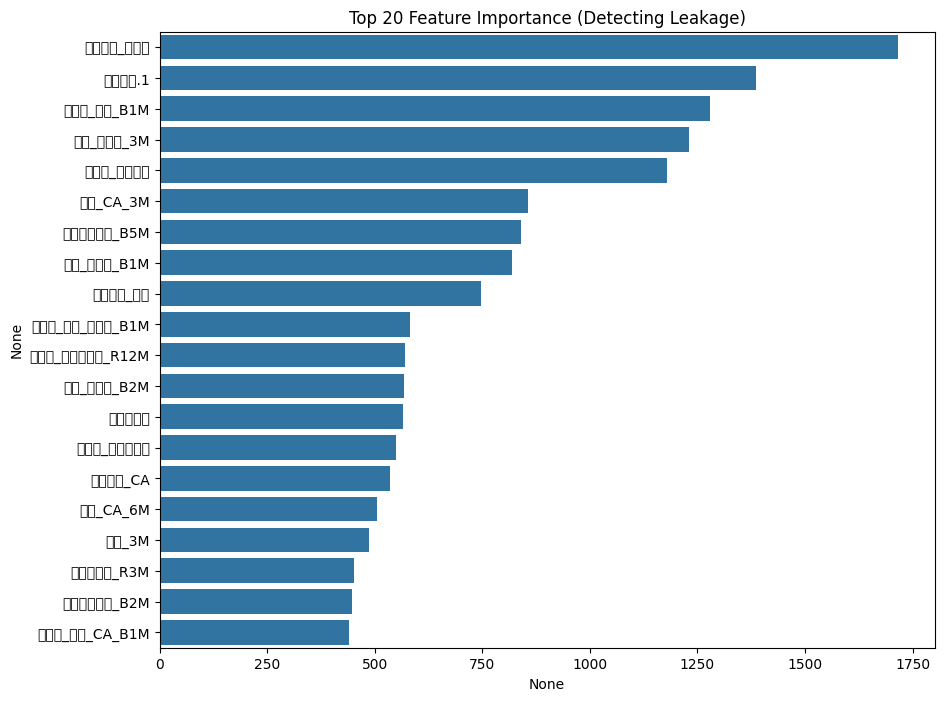

⚠️ 아래 변수들이 누수의 주범일 확률이 높습니다. 리스트를 확인해 보세요:
['월중평잔_일시불', '기준년월.1', '변동률_잔액_B1M', '평잔_일시불_3M', '변동률_할부평잔', '평잔_CA_3M', '정상청구원금_B5M', '잔액_일시불_B1M', '월중평잔_할부', '변동률_잔액_일시불_B1M', '포인트_적립포인트_R12M', '잔액_일시불_B2M', '직장시도명', '변동률_일시불평잔', '월중평잔_CA', '평잔_CA_6M', '평잔_3M', '혜택수혜율_R3M', '정상청구원금_B2M', '변동률_잔액_CA_B1M']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델에서 피처 중요도 추출
ftr_importances_values = lgbm_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importance (Detecting Leakage)')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# 상위 20개 변수 명단 출력
print("⚠️ 아래 변수들이 누수의 주범일 확률이 높습니다. 리스트를 확인해 보세요:")
print(ftr_top20.index.tolist())

In [ ]:
# 1. 추가 검거된 위험 키워드 리스트
leakage_keywords = [
    '변동률', '평잔', '잔액', '청구원금', 'B1M', 'B2M', 'B3M', 'B4M', 'B5M',
    '기준년월', '수혜율', '적립포인트'
]

In [ ]:
# 1. 추가 검거된 위험 키워드 리스트
leakage_keywords = [
    '변동률', '평잔', '잔액', '청구원금'
]

# 2. 제외할 컬럼 리스트 생성
additional_drop = [col for col in X.columns if any(word in col for word in leakage_keywords)]

# 3. 기존 X에서 이 변수들을 제외하고 다시 구성
X_refined = X.drop(columns=additional_drop)

print(f"제거된 누수 의심 컬럼: {len(additional_drop)}개")
print(f"남은 피처 수: {X_refined.shape[1]}개")
print(f"남은 피처 예시: {X_refined.columns.tolist()[:10]}")

제거된 누수 의심 컬럼: 64개
남은 피처 수: 127개
남은 피처 예시: ['캠페인접촉일수_R12M', '기준년월.1', '혜택수혜율_R3M', '기준년월.2', '_1순위업종', '_2순위업종', '_3순위업종', '_1순위쇼핑업종', '_2순위쇼핑업종', '_3순위쇼핑업종']


In [ ]:
# 데이터 분리 (X_refined 사용)
X_train_ref = X_refined[train_df['발급회원번호'].isin(train_ids)]
y_train_ref = y[train_df['발급회원번호'].isin(train_ids)]
X_test_ref = X_refined[train_df['발급회원번호'].isin(test_ids)]
y_test_ref = y[train_df['발급회원번호'].isin(test_ids)]

# 카테고리 변환
cat_features_ref = X_train_ref.select_dtypes(include=['object']).columns.tolist()
for col in cat_features_ref:
    X_train_ref[col] = X_train_ref[col].astype('category')
    X_test_ref[col] = X_test_ref[col].astype('category')

# 모델 학습
lgbm_model.fit(
    X_train_ref, y_train_ref,
    eval_set=[(X_test_ref, y_test_ref)],
    eval_metric='binary_logloss',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
)

# [중요] Recall 0.86을 맞추기 위한 Threshold 자동 조절 코드
y_probs_ref = lgbm_model.predict_proba(X_test_ref)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_ref, y_probs_ref)
idx = (np.abs(recalls - 0.86)).argmin()
best_threshold = thresholds[idx]

y_pred_ref = (y_probs_ref >= best_threshold).astype(int)
print(f"\n최적 임계값: {best_threshold:.4f}")
print(classification_report(y_test_ref, y_pred_ref))

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.363034
[200]	valid_0's binary_logloss: 0.324236
[300]	valid_0's binary_logloss: 0.315369
[400]	valid_0's binary_logloss: 0.31178
[500]	valid_0's binary_logloss: 0.309205
[600]	valid_0's binary_logloss: 0.30723
[700]	valid_0's binary_logloss: 0.305705
[800]	valid_0's binary_logloss: 0.304416
[900]	valid_0's binary_logloss: 0.303276
[1000]	valid_0's binary_logloss: 0.302271
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.302271

최적 임계값: 0.2142
              precision    recall  f1-score   support

           0       0.98      0.67      0.80    106724
           1       0.18      0.86      0.30      9237

    accuracy                           0.69    115961
   macro avg       0.58      0.77      0.55    115961
weighted avg       0.92      0.69      0.76    115961



In [ ]:
# Recall을 0.86에서 0.75~0.80 사이로 조정하여 Precision과의 합의점 찾기
target_recall_new = 0.78 # 0.86에서 조금 하향
idx_new = (np.abs(recalls - target_recall_new)).argmin()
new_threshold = thresholds[idx_new]

y_pred_refined = (y_probs_ref >= new_threshold).astype(int)

print(f"✅ 새로운 임계값: {new_threshold:.4f} (Target Recall: {recalls[idx_new]:.2f})")
print(classification_report(y_test_ref, y_pred_refined))

✅ 새로운 임계값: 0.2901 (Target Recall: 0.78)
              precision    recall  f1-score   support

           0       0.98      0.76      0.85    106724
           1       0.22      0.78      0.34      9237

    accuracy                           0.76    115961
   macro avg       0.60      0.77      0.60    115961
weighted avg       0.92      0.76      0.81    115961



In [ ]:
# 모델 파라미터를 좀 더 '보수적'으로 수정
lgbm_model_precision = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,   # 더 천천히 정밀하게 학습
    num_leaves=24,        # 복잡도를 약간 낮춤
    max_depth=6,
    scale_pos_weight=3,   # 가중치를 낮춰서 Precision 확보
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=42,
    verbose=-1
)

In [ ]:
# 기존 scale_pos_weight를 1~2 정도로 낮춰서 학습해 보세요.
lgbm_model_precision = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=20,          # 모델을 더 단순하게 (과적합 방지)
    max_depth=5,
    scale_pos_weight=5,   # 가중치를 대폭 낮춤
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42,
    verbose=-1
)

lgbm_model_precision.fit(X_train_ref, y_train_ref,
                         eval_set=[(X_test_ref, y_test_ref)],
                         callbacks=[early_stopping(stopping_rounds=50)])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.258149


LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=1000,
               num_leaves=20, random_state=42, reg_alpha=1.0, reg_lambda=1.0,
               scale_pos_weight=5, verbose=-1)

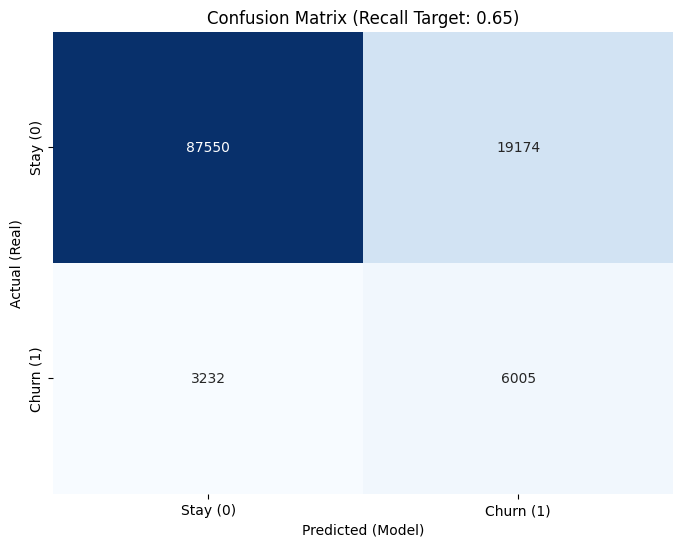


--- [최종 성능 평가 리포트] ---
적용된 임계값: 0.1567
              precision    recall  f1-score   support

           0       0.96      0.82      0.89    106724
           1       0.24      0.65      0.35      9237

    accuracy                           0.81    115961
   macro avg       0.60      0.74      0.62    115961
weighted avg       0.91      0.81      0.84    115961



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# 1. 학습된 모델로 테스트 데이터의 '이탈 확률' 추출
# 이 부분이 빠져서 NameError가 발생했습니다.
y_probs_precision = lgbm_model_precision.predict_proba(X_test_ref)[:, 1]

# 2. Precision을 높이기 위한 임계값(Threshold) 설정
# Recall 0.65를 목표로 하면 Precision이 이전보다 상승합니다.
target_recall_p = 0.65
precisions, recalls, thresholds = precision_recall_curve(y_test_ref, y_probs_precision)
idx_p = (np.abs(recalls - target_recall_p)).argmin()
p_threshold = thresholds[idx_p]

# 3. 최적 임계값을 적용하여 최종 예측값(0 또는 1) 생성
y_pred_final = (y_probs_precision >= p_threshold).astype(int)

# 4. 혼동 행렬(Confusion Matrix) 계산 및 시각화
cm = confusion_matrix(y_test_ref, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Stay (0)', 'Churn (1)'],
            yticklabels=['Stay (0)', 'Churn (1)'])

plt.xlabel('Predicted (Model)')
plt.ylabel('Actual (Real)')
plt.title(f'Confusion Matrix (Recall Target: {recalls[idx_p]:.2f})')
plt.show()

# 5. 최종 성능 지표 출력
print("\n--- [최종 성능 평가 리포트] ---")
print(f"적용된 임계값: {p_threshold:.4f}")
print(classification_report(y_test_ref, y_pred_final))

In [ ]:
# [1] 목표 Recall을 다시 0.86으로 상향
target_recall_high = 0.86

# 확률 예측 (기존 학습된 모델 사용)
y_probs_high = lgbm_model_precision.predict_proba(X_test_ref)[:, 1]

# Precision-Recall 곡선에서 목표 Recall에 해당하는 임계값 찾기
precisions, recalls, thresholds = precision_recall_curve(y_test_ref, y_probs_high)
idx_h = (np.abs(recalls - target_recall_high)).argmin()
h_threshold = thresholds[idx_h]

# 새로운 임계값 적용
y_pred_high = (y_probs_high >= h_threshold).astype(int)

print(f"✅ Recall 0.86을 위한 새로운 임계값: {h_threshold:.4f}")
print(classification_report(y_test_ref, y_pred_high))

✅ Recall 0.86을 위한 새로운 임계값: 0.1130
              precision    recall  f1-score   support

           0       0.98      0.58      0.73    106724
           1       0.15      0.86      0.25      9237

    accuracy                           0.60    115961
   macro avg       0.56      0.72      0.49    115961
weighted avg       0.91      0.60      0.69    115961

